In [1]:
# импортируем необходимые библиотеки

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import shap
import warnings
import plotly.graph_objects as go
import itertools

from itertools import product
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)
warnings.filterwarnings("ignore")

### Загрузка данных

In [2]:
#загружаем данные

df1 = pd.read_excel('C:/Users/micha/Desktop/Диплом АВТФ/МассивЖКиВУ(февр. все с полипами).xls', 
                    sheet_name='список', usecols = [
                        'ФИО', 'возраст', 'пол: 1 - муж.; 2 - жен.', 'стадия', 'group'
                    ])
# переменуем слишком длинные название столбцов
df1.rename({'пол: 1 - муж.; 2 - жен.':'пол'}, 
           axis = 1, 
           inplace = True)
#-------------------------------------------------------------------------------------------------------

df2 = pd.read_excel('C:/Users/micha/Desktop/Диплом АВТФ/МассивЖКиВУ(февр. все с полипами).xls', 
                    sheet_name='ЛП', header = 1, usecols = [
                        
                        'ФИО', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11',
       'e12', 'e13', 'e14', 'e15', 'e16', 'e17', 'e18', 'e19', 'e20', 'e21',
       'e22 (насыщ)', 'e23 (ненасыщ)', 'e24 (мононенасыщ)',
       'e25 (полиненасыщ)', 'e26 (омега-3)', 'e27 (омега-6)',
       'e28 (омега3(EPA+DHA))', 'e27/e26', 'e22/e23', 'e22/e25', 's1', 's2',
       's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13',
       's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22 (насыщ)',
       's23 (ненасыщ)', 's24 (мононенасыщ)', 's25 (полиненасыщ)',
       's26 (омега-3)', 's27 (омега-6)', 's28 (омега3(EPA+DHA))', 's27/s26',
       's22/s23', 's22/s25'
                        
                        
                    ])

#-------------------------------------------------------------------------------------------------------

df3 = pd.read_excel('C:/Users/micha/Desktop/Диплом АВТФ/МассивЖКиВУ(февр. все с полипами).xls', 
                    sheet_name='ВУХ', usecols = [
                        
                        'фио', 'Доля дискоцитов', 'Доля сфероцитов',
       'Доля деформир.клеток', 'Характер поверхности:1-гладкая,2-бугрист,3-шиповид,4-мульти  ',
       'Радиус на 1МГц', 'Радиус на 0,5МГц', 'Радиус на 0,1МГц',
       'Радиус на 0,05МГц', 'Средний радиус', 'Скорость движения Эр',
       'Амплитуда деформации на 1МГц', 'Степень деформации на 0,5МГц в %',
       'Обобщенная жесткость', 'Обобщенная вязкость', 'Агрегация на 1МГц',
       'Агрегация на 0,5МГц', 'Агрегация на 0,1МГц', 'Агрегация на 0,05МГц',
       'Гемолиз на 1МГц', 'Гемолиз на 0,5МГц', 'Гемолиз на 0,1МГц',
       'Гемолиз на 0,05МГц', 'Поляризуемость на 1МГц',
       'Поляризуемость на 0,5МГц', 'Поляризуемость на 0,1МГц',
       'Поляризуемость на 0,05МГц', 'Относительная поляризуемость',
       'Электропроводность', 'Емкость мембран', 'Равновесная частота',
       'Дипольный момент'
                        
                    ])

df3.rename({'фио':'ФИО'}, axis = 1, inplace = True)

#-------------------------------------------------------------------------------------------------------
#df4 = pd.read_excel('C:/Users/micha/Desktop/Диплом АВТФ/МассивЖКиВУ(февр. все с полипами).xls', 
#                    sheet_name='БХ', usecols = [
#                        'ФИО', 'дата анализа', 'карта/файл', 'Альбумины', 'АЛТ', 'АСТ',
#       'Мочевая кислота', 'Креатинин', 'Общий билирубин', 'Прямой билирубин',
#       'Непрямой билирубин', 'Общий холестерин', 'ХС ЛПВП', 'Триглицериды',
#       'Мочевина', 'Общий белок', 'Глюкоза крови', 'Железо сыворотки',
#       'Амилаза крови', 'Ретикулоциты', 'ГГТП'
#                        
#                    ])


#df4.rename({'дата анализа':'Дата взятия БХ'}, axis = 1, inplace = True)"""

In [3]:
df1 = df1.query('group != 0')

In [4]:
df1.drop(columns = ['group'], inplace = True)

Создадим **три** dataframe. Состоящих из:

- Липидного профиля
- Вязкоупругих характеристик

In [6]:
df_1 = pd.merge(df1, df2, how = 'left')

df_2 = pd.merge(df1, df3, how = 'left')

Посмотрим на полученный DataFrame состоящих из обоих характеристик **ВУХ**

In [8]:
df_2

,ФИО,возраст,пол,стадия,Доля дискоцитов,Доля сфероцитов,Доля деформир.клеток,"Характер поверхности:1-гладкая,2-бугрист,3-шиповид,4-мульти",Радиус на 1МГц,"Радиус на 0,5МГц","Радиус на 0,1МГц","Радиус на 0,05МГц",Средний радиус,Скорость движения Эр,Амплитуда деформации на 1МГц,"Степень деформации на 0,5МГц в %",Обобщенная жесткость,Обобщенная вязкость,Агрегация на 1МГц,"Агрегация на 0,5МГц","Агрегация на 0,1МГц","Агрегация на 0,05МГц",Гемолиз на 1МГц,"Гемолиз на 0,5МГц","Гемолиз на 0,1МГц","Гемолиз на 0,05МГц",Поляризуемость на 1МГц,"Поляризуемость на 0,5МГц","Поляризуемость на 0,1МГц","Поляризуемость на 0,05МГц",Относительная поляризуемость,Электропроводность,Емкость мембран,Равновесная частота,Дипольный момент
0,Алина В.А.,44.0,2,NaN,75,18,19,1,3.51,3.52,3.57,3.55,3.56,8.2,8.14,69.0,5.94,6.02,0.004,0.007,0.008,0.008,0.0,0.0,0.0,1.0,4.92,2.85,2.03,3.70,0.75,4.88,6.45,0.55,7.11
1,Алина И.В.,54.0,2,NaN,86,11,12,1,3.67,3.65,3.60,3.62,3.65,9.3,9.21,86.0,5.67,5.18,0.017,0.015,0.011,0.015,0.0,0.0,0.0,0.0,4.59,3.54,1.19,3.00,0.65,5.84,8.26,0.37,7.85
2,Ананьева Т.А.,56.0,2,NaN,70,21,18,1,3.43,3.49,3.44,3.49,3.44,7.8,7.62,67.0,6.57,5.94,0.015,0.020,0.015,0.015,0.0,0.0,0.0,0.0,3.93,2.17,1.49,2.94,0.75,5.74,6.37,0.54,7.51
3,Антонов Д.А.,62.0,1,NaN,81,11,27,1,3.52,3.62,3.54,3.62,3.57,7.1,7.64,68.0,6.87,6.12,0.015,0.012,0.010,0.009,0.0,0.0,0.0,0.0,5.06,3.21,2.08,3.87,0.76,5.11,6.94,0.57,6.85
4,Бакланов А.А.,64.0,1,NaN,69,23,18,1,3.59,3.62,3.47,3.54,3.58,8.2,8.19,74.0,6.51,5.93,0.010,0.009,0.008,0.010,0.0,0.0,0.0,0.0,6.54,3.79,2.18,4.90,0.75,5.10,7.25,0.52,7.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Радюк А.С.,73.0,2,NaN,56,32,40,2,3.55,3.57,3.54,3.55,3.55,6.3,6.92,58.0,8.65,6.94,0.014,0.017,0.014,0.013,0.0,0.0,0.0,0.0,4.42,3.09,1.25,2.94,0.66,6.84,6.77,0.73,5.63
173,Томилин А.А.,NaN,1,NaN,55,40,37,1,3.50,3.52,3.53,3.54,3.52,6.4,6.70,58.0,8.24,7.14,0.014,0.018,0.020,0.018,0.0,0.0,0.0,0.0,3.26,2.18,1.97,2.04,0.63,5.98,6.12,0.30,5.24
174,Торопова Т.В.,60.0,2,NaN,57,32,38,1,3.55,3.45,3.59,3.46,3.50,5.9,6.59,57.0,8.67,7.04,0.031,0.045,0.050,0.034,0.0,0.0,0.0,0.0,4.27,2.98,1.67,2.72,0.64,5.94,5.47,0.63,5.91
175,Трусова Н.Ю.,56.0,2,NaN,54,26,32,1,3.58,3.56,3.52,3.54,3.54,6.7,7.02,64.0,7.71,6.63,0.013,0.014,0.013,0.015,0.0,3.7,0.0,3.4,5.23,3.17,2.14,3.27,0.63,5.87,6.12,0.60,6.24


Посмотрим на полученный DataFrame состоящих из обоих характеристик **ЛП** 

In [9]:
df_1

,ФИО,возраст,пол,стадия,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12,e13,e14,e15,e16,e17,e18,e19,e20,e21,e22 (насыщ),e23 (ненасыщ),e24 (мононенасыщ),e25 (полиненасыщ),e26 (омега-3),e27 (омега-6),e28 (омега3(EPA+DHA)),e27/e26,e22/e23,e22/e25,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,s22 (насыщ),s23 (ненасыщ),s24 (мононенасыщ),s25 (полиненасыщ),s26 (омега-3),s27 (омега-6),s28 (омега3(EPA+DHA)),s27/s26,s22/s23,s22/s25
0,Алина В.А.,44.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Алина И.В.,54.0,2,NaN,0.607225,1.186655,0.471389,32.77162,1.577557,1.263242,0.324470,0.000000,15.88712,14.448550,1.175011,15.905910,0.008211,0.112096,0.308925,0.831194,9.450727,0.471148,1.067674,0.818721,1.322125,51.25669,48.75288,18.464360,30.28852,2.724091,27.564430,1.793273,10.118760,1.051357,1.692281,0.272454,0.208124,0.207294,20.24819,0.810662,0.807060,0.179501,0.034940,5.926613,18.86170,1.319848,44.47628,0.114429,0.151555,0.129356,0.657146,4.086957,0.514554,0.141216,0.127250,0.724869,27.15660,72.84340,21.79927,51.04412,1.518228,49.49095,1.239423,32.597830,0.372808,0.532022
2,Ананьева Т.А.,56.0,2,NaN,1.956079,2.433713,1.093093,31.42165,2.114383,2.759775,0.418921,0.358162,13.81388,13.526060,0.670917,14.152350,0.054301,0.029768,0.213473,1.043332,9.062487,0.559387,1.576010,0.676574,2.065681,51.19164,48.80836,19.071140,29.73722,3.331411,26.047650,2.625068,7.818804,1.048829,1.721467,0.794270,1.123512,0.493638,24.60766,0.764946,1.594425,0.137323,0.000000,6.753213,18.15759,1.397584,34.05708,0.125681,0.224145,0.197626,0.794306,4.880010,0.754603,0.297306,0.492604,1.352478,35.03529,64.96471,21.91454,43.05016,2.823830,40.22633,2.107081,14.245310,0.539297,0.813825
3,Антонов Д.А.,62.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Бакланов А.А.,64.0,1,NaN,0.127606,0.833882,0.341931,33.36837,0.549437,0.910513,0.424854,0.113197,31.43534,8.645023,0.770048,8.749211,0.266258,0.038523,0.187567,0.644988,7.266303,0.328932,1.507695,0.965443,2.524875,66.79824,33.20176,10.875020,22.32674,3.857774,18.355760,2.853808,4.758123,2.011889,2.991850,0.153064,1.273674,0.411181,29.41140,0.501531,1.354620,0.368816,0.091118,19.207010,11.66067,0.904880,25.94956,0.157238,0.095007,0.143202,1.505072,4.786327,0.190451,0.151602,0.007451,1.676131,50.98238,49.01762,14.42170,34.59592,1.969040,32.53577,1.866582,16.523670,1.040083,1.473653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Радюк А.С.,73.0,2,NaN,0.760239,0.393019,0.106723,31.54946,0.135356,0.988053,0.278394,0.070715,30.15878,9.428253,0.590234,7.986097,0.129482,0.072690,0.339722,0.926479,9.749278,0.271700,1.651200,2.409565,2.004559,63.37610,36.62390,11.141900,25.48200,4.758514,20.652780,2.276259,4.340174,1.730457,2.487092,0.086224,0.703585,0.212862,31.41882,0.371685,1.379551,0.328105,0.076620,24.700930,12.57778,1.338318,19.49329,0.070845,0.223545,0.161719,0.847458,3.977990,0.284344,0.144317,0.389942,1.212067,57.52137,42.47863,15.66734,26.81129,2.109898,24.62477,1.496411,11.671070,1.354125,2.145416
173,Томилин А.А.,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
174,Торопова Т.В.,60.0,2,NaN,0.167734,0.716745,0.086341,37.09685,0.182090,2.167144,0.176381,0.048477,41.83622,

Даный фрэм содержит информацию о 180 пациентах, которые имеют 96 различных признаков

### Очистка данных

In [10]:
# Посмотрим на пропуски
df_1.isna().sum()

ФИО                       0
возраст                   1
пол                       0
стадия                   54
e1                       13
e2                       13
e3                       13
e4                       13
e5                       13
e6                       13
e7                       13
e8                       13
e9                       13
e10                      13
e11                      13
e12                      13
e13                      13
e14                      13
e15                      13
e16                      13
e17                      13
e18                      13
e19                      13
e20                      13
e21                      13
e22 (насыщ)              13
e23 (ненасыщ)            13
e24 (мононенасыщ)        13
e25 (полиненасыщ)        13
e26 (омега-3)            13
e27 (омега-6)            13
e28 (омега3(EPA+DHA))    13
e27/e26                  13
e22/e23                  13
e22/e25                  13
s1                  

In [11]:
# Посмотрим на пропуски
df_2.isna().sum()

ФИО                                                               0
возраст                                                           1
пол                                                               0
стадия                                                           54
Доля дискоцитов                                                   0
Доля сфероцитов                                                   0
Доля деформир.клеток                                              0
Характер поверхности:1-гладкая,2-бугрист,3-шиповид,4-мульти       0
Радиус на 1МГц                                                    0
Радиус на 0,5МГц                                                  0
Радиус на 0,1МГц                                                  0
Радиус на 0,05МГц                                                 0
Средний радиус                                                    0
Скорость движения Эр                                              0
Амплитуда деформации на 1МГц                    

Так как по 13 пациантам отсутствуют показатели ЛП, исключим их из рассмотрения

In [12]:
df_1 = df_1[~df_1['e1'].isna()]

In [13]:
# заменим пропуск возсраста одного пациента на медиану
df_2 = df_2.fillna({'возраст':df_2['возраст'].median()})

In [14]:
df_1.shape

(164, 66)

In [15]:
df_2.shape

(177, 35)

Таким образом фрейм включающий информацию по ВУХ содержит информацию о 177 пациентах, фрейм включающий информацию по ЛП о 164 пациентах.

### Классификация с целевой меткой "стадия"

In [16]:
#если пропуск, то не болен раком
df_1['стадия'] = df_1['стадия'].fillna(0)
df_2['стадия'] = df_2['стадия'].fillna(0)

Для обучения будем использовать модели основанные на деревьях решений: Random Forest и CatBoost(градиентный бустинг), так как данные модел сами выбирают важные признаки и соответсвенно хорошо работают с задачими, которые имеют много признаков, как в нашем случае

### 1. Выявление пациентов, которые имеют рак (1-4 стадия)

In [17]:
# если стадия 0, то 0, иначе 1
df_1['стадия_0_1'] = np.where(df_1['стадия'] == 0, 0, 1)
#----------------------------------------------------------------------------------------
df_2['стадия_0_1'] = np.where(df_2['стадия'] == 0, 0, 1)

#посмотрим насколько сбалансированный у нас получились классы
df_1['стадия_0_1'].value_counts(normalize = True)*100

1    69.512195
0    30.487805
Name: стадия_0_1, dtype: float64

In [44]:
data = df_1.groupby('стадия_0_1').agg({'e1':'count'})

In [38]:
data

,стадия_0_1,e1
0,0,50
1,1,114


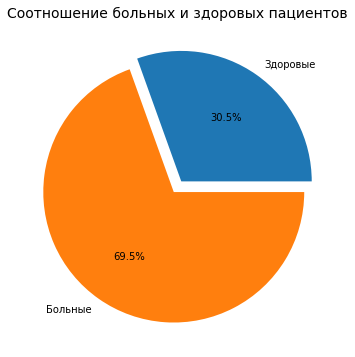

In [54]:
pie, ax = plt.subplots(figsize=[10,6])
plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*2, labels = ['Здоровые', "Больные"])
plt.title("Соотношение больных и здоровых пациентов", fontsize=14);
pie.savefig("НТИPieChart.png")

Так как пациентов, у которых обнаружей рак составляют подавляющее большинство, мы имеем дело с несбалансированными классами и следовательно, для разбиения на обучающую и проверочную выборку, нам необходимо использовать стратифицированную выборку. Для обучения возьмем 25% и для тренировки 75% значений.

In [16]:
df_2.rename({'Поляризуемость на 0,05МГц':'Поляризуемость на 05МГц',
                 'Характер поверхности:1-гладкая,2-бугрист,3-шиповид,4-мульти  ':'Характер поверхности'},
               axis = 1, inplace = True)
df_2.columns = df_2.columns.str.replace(',',' ')

NameError: name 'X_train2' is not defined

In [18]:
trainset1 = df_1.drop(columns=['стадия_0_1', 'ФИО', 'стадия'])
target1 = df_1['стадия_0_1']

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(trainset1, target1, random_state = 35,
                                                    test_size=0.25, stratify=target1)
#----------------------------------------------------------------------------------------
trainset2 = df_2.drop(columns=['стадия_0_1', 'ФИО', 'стадия'])
target2 = df_2['стадия_0_1']

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(trainset2, target2, random_state = 35,
                                                    test_size=0.25, stratify=target2)

Создадим модели с настройкой только таких гиперпараметров, как глубина деревьев, число деревьев и вес классов. Вес классов нам необходимо задать по той причине, что нам категорически важно не ошибаться в тех случаях, когда у пациент есть рак. Также зададим random_state для воспроизводимости результатов.


*Гиперпараметры для модели были предварительно подобраны*.

In [19]:
#----------------------------------------------------------------------------------------
Tree1 = DecisionTreeClassifier(random_state = 13, max_depth = 2,
                               min_samples_split=6, min_samples_leaf = 6,  
                               class_weight={0:.3, 1:.7})

RF1 = RandomForestClassifier(random_state = 13, max_depth = 7, 
                            n_estimators = 400, class_weight={0:.3, 1:.7})
# n_estimators = 400, max_depth=7 - лучшие параметры согласно  greed search cv
Cat1 = CatBoostClassifier(random_state = 13, verbose = 0, 
                         n_estimators = 400, max_depth=7, 
                         class_weights = [0.3, 0.7])
XGB1 = XGBClassifier(random_state = 13, max_depth=5, n_estimators=100,
                    class_weights = [0.3, 0.7])
LGBM1 = LGBMClassifier(boosting_type='gbdt',  random_state = 13, max_depth=3, n_estimators=500,
                      class_weight={0:.3, 1:.7})
#----------------------------------------------------------------------------------------
Tree2 = DecisionTreeClassifier(random_state = 13, max_depth = 2,
                               min_samples_split = 6, min_samples_leaf = 10,  
                               class_weight={0:.3, 1:.7})

RF2 = RandomForestClassifier(random_state = 13, max_depth = 6, 
                            n_estimators = 200, class_weight={0:.3, 1:.7})
# n_estimators = 300, max_depth=8 - лучшие параметры согласно  greed search cv
Cat2 = CatBoostClassifier(random_state = 13, verbose = 0, 
                         n_estimators = 300, max_depth = 8, 
                         class_weights = [0.3, 0.7])

XGB2 = XGBClassifier(random_state = 13, max_depth=3, n_estimators=600,
                    class_weights = [0.3, 0.7])
LGBM2 = LGBMClassifier(boosting_type='dart',random_state = 13, max_depth=6, n_estimators=600,
                      class_weight={0:.3, 1:.7})

### Подбор гиперпараметров для моделей CatBoost

In [64]:
grid = {  'min_child_samples': list(range(1,10))}

grid_search_result = Cat1.grid_search(grid, 
                                       X=X_train1, 
                                       y=Y_train1, 
                                       plot=True,
                                       stratified = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.2975314	best: 0.2975314 (0)	total: 1.97s	remaining: 15.8s
1:	loss: 0.2975314	best: 0.2975314 (0)	total: 3.78s	remaining: 13.2s
2:	loss: 0.2975314	best: 0.2975314 (0)	total: 5.63s	remaining: 11.3s
3:	loss: 0.2975314	best: 0.2975314 (0)	total: 7.35s	remaining: 9.19s
4:	loss: 0.2975314	best: 0.2975314 (0)	total: 9.08s	remaining: 7.27s
5:	loss: 0.2975314	best: 0.2975314 (0)	total: 10.9s	remaining: 5.44s
6:	loss: 0.2975314	best: 0.2975314 (0)	total: 12.7s	remaining: 3.63s
7:	loss: 0.2975314	best: 0.2975314 (0)	total: 14.6s	remaining: 1.82s
8:	loss: 0.2975314	best: 0.2975314 (0)	total: 16.4s	remaining: 0us
Estimating final quality...


KeyboardInterrupt: 

In [61]:
grid = { 'max_depth': list(range(3,9)),
         'n_estimators': list(range(200,1000,100))}

grid_search_result = Cat2.grid_search(grid, 
                                       X=X_train1, 
                                       y=Y_train1, 
                                       plot=True,
                                       stratified = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.2992915	best: 0.2992915 (0)	total: 289ms	remaining: 13.6s
1:	loss: 0.2992915	best: 0.2992915 (0)	total: 637ms	remaining: 14.7s
2:	loss: 0.2992915	best: 0.2992915 (0)	total: 1.28s	remaining: 19.3s
3:	loss: 0.2992915	best: 0.2992915 (0)	total: 1.91s	remaining: 21s
4:	loss: 0.2992915	best: 0.2992915 (0)	total: 2.74s	remaining: 23.6s
5:	loss: 0.2992915	best: 0.2992915 (0)	total: 3.63s	remaining: 25.4s
6:	loss: 0.2992915	best: 0.2992915 (0)	total: 4.72s	remaining: 27.7s
7:	loss: 0.2992915	best: 0.2992915 (0)	total: 5.99s	remaining: 30s
8:	loss: 0.3130205	best: 0.2992915 (0)	total: 6.31s	remaining: 27.3s
9:	loss: 0.3130205	best: 0.2992915 (0)	total: 6.75s	remaining: 25.6s
10:	loss: 0.3130205	best: 0.2992915 (0)	total: 7.36s	remaining: 24.8s
11:	loss: 0.3130205	best: 0.2992915 (0)	total: 8.08s	remaining: 24.2s


KeyboardInterrupt: 

In [69]:
grid = { 'max_depth': list(range(3,9)),
         'n_estimators': list(range(200,1000,100))}

grid_search_result = Cat.grid_search(grid, 
                                       X=X_train2, 
                                       y=Y_train2, 
                                       plot=True,
                                       stratified = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.2148134	best: 0.2148134 (0)	total: 185ms	remaining: 8.71s
1:	loss: 0.2148134	best: 0.2148134 (0)	total: 495ms	remaining: 11.4s
2:	loss: 0.2148134	best: 0.2148134 (0)	total: 884ms	remaining: 13.3s
3:	loss: 0.2148134	best: 0.2148134 (0)	total: 1.43s	remaining: 15.7s
4:	loss: 0.2148134	best: 0.2148134 (0)	total: 2s	remaining: 17.2s
5:	loss: 0.2148134	best: 0.2148134 (0)	total: 2.64s	remaining: 18.5s
6:	loss: 0.2148134	best: 0.2148134 (0)	total: 3.37s	remaining: 19.7s
7:	loss: 0.2148134	best: 0.2148134 (0)	total: 4.2s	remaining: 21s
8:	loss: 0.2137357	best: 0.2137357 (8)	total: 4.41s	remaining: 19.1s
9:	loss: 0.2137357	best: 0.2137357 (8)	total: 4.76s	remaining: 18.1s
10:	loss: 0.2137357	best: 0.2137357 (8)	total: 5.18s	remaining: 17.4s
11:	loss: 0.2137357	best: 0.2137357 (8)	total: 5.72s	remaining: 17.2s
12:	loss: 0.2137357	best: 0.2137357 (8)	total: 6.39s	remaining: 17.2s
13:	loss: 0.2137357	best: 0.2137357 (8)	total: 7.19s	remaining: 17.5s
14:	loss: 0.2137357	best: 0.2137357 

CatBoostError: only one of the parameters depth, max_depth should be initialized.

### Подбор гиперпараметров дерева решений

In [34]:
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='macro')

In [39]:
param_grid = {
    'max_depth': list(range(3,10)),
    'min_samples_split': list(range(1,8)),
    'min_samples_leaf': list(range(1,8))
}

In [41]:
grid_search1 = GridSearchCV(estimator = Tree1, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring=f1).fit(X_train1, Y_train1)

grid_search2 = GridSearchCV(estimator = Tree2, param_grid = param_grid, 
                         cv = 5, n_jobs = -1, verbose = 2, scoring=f1).fit(X_train2, Y_train2)

Fitting 5 folds for each of 343 candidates, totalling 1715 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1715 out of 1715 | elapsed:    1.3s finished


Fitting 5 folds for each of 343 candidates, totalling 1715 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1715 out of 1715 | elapsed:    1.2s finished


In [42]:
grid_search1.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.3, 1: 0.7},
                       criterion='gini', max_depth=3, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=13, splitter='best')

In [43]:
grid_search2.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.3, 1: 0.7},
                       criterion='gini', max_depth=3, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=13, splitter='best')

### Подбор гиперпараметров для моделей XGboost

In [67]:
param_grid = {
    'max_depth': list(range(3,10)),
    'n_estimators': list(range(100,900,100))
}

grid_search1 = GridSearchCV(estimator = XGB1, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring=f1).fit(X_train1, Y_train1)

grid_search2 = GridSearchCV(estimator = XGB2, param_grid = param_grid, 
                         cv = 5, n_jobs = -1, verbose = 2, scoring=f1).fit(X_train2, Y_train2)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    8.1s finished


Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    3.1s finished


In [68]:
grid_search1.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=13,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [69]:
grid_search2.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=13,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Подбор гиперпараметров для моделей LGBMboost

In [20]:
param_grid = {
    'max_depth': list(range(3,10)),
    'n_estimators': list(range(100,900,100)),
    'boosting_type' : ['gbdt','dart', 'goss', 'rf']
}

grid_search1 = GridSearchCV(estimator = LGBM1, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = False, scoring=f1).fit(X_train1, Y_train1)

grid_search2 = GridSearchCV(estimator = LGBM2, param_grid = param_grid, 
                         cv = 5, n_jobs = -1, verbose = False, scoring=f1).fit(X_train2, Y_train2)

NameError: name 'f1' is not defined

In [114]:
grid_search1.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight={0: 0.3, 1: 0.7},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=3, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=13, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [115]:
grid_search2.best_estimator_

LGBMClassifier(boosting_type='dart', class_weight={0: 0.3, 1: 0.7},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=6, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=600, n_jobs=-1, num_leaves=31,
               objective=None, random_state=13, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

### Подбор гиперпараметров для моделей RF

In [96]:
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='macro')

In [104]:
param_grid = {
    'bootstrap': [True],
    'max_depth': list(range(3,10)),
    'n_estimators': list(range(100,900,100))
}

In [112]:
grid_search = GridSearchCV(estimator = RF, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring=f1)

grid_search1 = GridSearchCV(estimator = RF1, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring=f1)

grid_search2 = GridSearchCV(estimator = RF2, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring=f1)

In [113]:
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   12.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={0: 0.3, 1: 0.7},
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=13,
                         

In [114]:
grid_search1.fit(X_train1, Y_train1)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   12.4s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={0: 0.3, 1: 0.7},
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=13,
                         

In [115]:
grid_search2.fit(X_train2, Y_train2)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:   11.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={0: 0.3, 1: 0.7},
                                              criterion='gini', max_depth=8,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=300, n_jobs=None,
                                              oob_score=False, random_state=13,
                         

In [116]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.3, 1: 0.7}, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=13, verbose=0, warm_start=False)

In [117]:
grid_search1.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.3, 1: 0.7}, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=400, n_jobs=None, oob_score=False,
                       random_state=13, verbose=0, warm_start=False)

In [118]:
grid_search2.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.3, 1: 0.7}, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=13, verbose=0, warm_start=False)

### Проведем кросс валидацию

Проведем кросс-валидацию и оценим такие меетрики, как f1 и recall. При кросс валидации число разбиений будем принимать равным 5

In [21]:
#проверим на кросс валидации
for i in [RF1, Cat1, XGB1, LGBM1]:
    #разделим тренировочную часть на 5 фолдов
    scores_f1 = cross_val_score(i, X_train1, Y_train1, cv = 5, scoring='f1')
    scores_rec = cross_val_score(i, X_train1, Y_train1, cv = 5, scoring='recall')
    print("Name model: ", type(i).__name__ )
    print("Recall array: ", scores_rec)
    print("Recall mean = {:.3f} ".format(scores_rec.mean()))
    print("F1 array: ", scores_f1)
    print("F1 mean = {:.3f} ".format(scores_f1.mean()))
    print("-------------------------------------------------------------")

Name model:  RandomForestClassifier
Recall array:  [0.94117647 0.76470588 0.94117647 0.94117647 0.82352941]
Recall mean = 0.882 
F1 array:  [0.86486486 0.83870968 0.84210526 0.91428571 0.82352941]
F1 mean = 0.857 
-------------------------------------------------------------
Name model:  CatBoostClassifier
Recall array:  [0.94117647 0.94117647 1.         1.         0.82352941]
Recall mean = 0.941 
F1 array:  [0.86486486 0.88888889 0.85       0.89473684 0.77777778]
F1 mean = 0.855 
-------------------------------------------------------------
Name model:  XGBClassifier
Recall array:  [1.         0.82352941 1.         0.88235294 0.82352941]
Recall mean = 0.906 
F1 array:  [0.89473684 0.84848485 0.89473684 0.88235294 0.82352941]
F1 mean = 0.869 
-------------------------------------------------------------
Name model:  LGBMClassifier
Recall array:  [1.         0.88235294 0.94117647 0.76470588 0.82352941]
Recall mean = 0.882 
F1 array:  [0.91891892 0.85714286 0.88888889 0.8125     0.848484

In [22]:
#проверим на кросс валидации
for i in [RF2, Cat2, XGB2, LGBM2]:
    #разделим тренировочную часть на 5 фолдов
    scores_f1 = cross_val_score(i, X_train2, Y_train2, cv = 5, scoring='f1')
    scores_rec = cross_val_score(i, X_train2, Y_train2, cv = 5, scoring='recall')
    print("Name model: ", type(i).__name__ )
    print("Recall array: ", scores_rec)
    print("Recall mean = {:.3f} ".format(scores_rec.mean()))
    print("F1 array: ", scores_f1)
    print("F1 mean = {:.3f} ".format(scores_f1.mean()))
    print("-------------------------------------------------------------")

Name model:  RandomForestClassifier
Recall array:  [0.89473684 0.89473684 0.88888889 0.88888889 0.94444444]
Recall mean = 0.902 
F1 array:  [0.87179487 0.94444444 0.94117647 0.94117647 0.94444444]
F1 mean = 0.929 
-------------------------------------------------------------
Name model:  CatBoostClassifier
Recall array:  [0.89473684 0.94736842 1.         0.88888889 1.        ]
Recall mean = 0.946 
F1 array:  [0.85       0.97297297 1.         0.94117647 0.94736842]
F1 mean = 0.942 
-------------------------------------------------------------
Name model:  XGBClassifier
Recall array:  [0.89473684 0.94736842 0.94444444 0.83333333 1.        ]
Recall mean = 0.924 
F1 array:  [0.87179487 0.97297297 0.97142857 0.90909091 0.94736842]
F1 mean = 0.935 
-------------------------------------------------------------
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_

Таким образом мы видим, что модели обученные только на данных ВУХ крови показывают более лучший результат, чем модели обученные только на данных ЛП.

Также можно заметить, что в общем во всех случаях модели имеют метрики точности от 0.87 до 0.95, что является довольно хорошим результатам, но тем не менее Recall в моделях обученных только на данных по ВУХ или ЛП дают только в одном случае Recall = 1 на кросс валидации, тогда как модели обученные на обоих характеристиках ошибаются только в 1 из 5 раз (Recal < 1). Таким образом комбинация обеих характеристик дает практически идеальный результат.

Обучим наши модели на тренировочной выбрке и проверим на тестовой. Далее построим AUC ROC и определим основные показатели точности классификации

In [61]:
for i in [[RF1, Cat1, XGB1, LGBM1]]:
    fpr = []
    tpr = []
    roc_auc = []
    pred = []
    print('----------------------------------------------------------------------------------------------------')
    for j in i:
        
        #обучение модели
        j.fit(X_train1, Y_train1)

        #получение результата в виде 0 и 1
        pred1 = j.predict(X_test1)
        pred.append(pred1)
        #получение результата в виде вероятности

        score1 = j.predict_proba(X_test1)
        score1 = score1[:,1]

        #accuracy
        accuracy1 = accuracy_score(Y_test1, pred1)

        #f1
        f1_1 = f1_score(Y_test1, pred1)    

        #precision
        precision1 = precision_score(Y_test1,pred1)    

        #recall
        recall1 = recall_score(Y_test1,pred1)    

        #confusion_matrix
        cnf_matrix1 = confusion_matrix(Y_test1, pred1)    

        #roc_auc
        fpr1, tpr1, threshold1 = roc_curve(Y_test1,score1) 
        roc_auc1 = auc(fpr1, tpr1)  
        
        fpr.append(fpr1)
        tpr.append(tpr1)
        roc_auc.append(roc_auc1)
#----------------------------------------------------------------------------------------    
        print("Name model: ", type(j).__name__ )
        print("Confusion matrix: \n",cnf_matrix1)    
        print("Scores: accuracy = {:.4f}, \t precision = {:.2f}, \t recall = {:.2f}, \t f1 = {:.2f}, \t auc = {:.4f}"\
              .format(accuracy1, precision1, recall1, f1_1, roc_auc1))   
    
model_name = ['RF - AUC: {:.2f}', 
              'Cat - AUC: {:.2f}', 
              'XGB - AUC: {:.2f}',
              'LGBM - AUC: {:.2f}']

# Построение ROC-AUC
    
      
marker = [dict(color='Crimson', width=3, dash='dash'),
         dict(color='SandyBrown', width=3, dash='dot'),
         dict(color='Blue', width=3, dash='dash'),
         dict(color='LimeGreen', width=3, dash='dot')] 

fig = go.Figure()

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)


for c in range(len(i)):

    name= model_name[c]

    fig.add_trace(go.Scatter(x=fpr[c],
                             y=tpr[c], 
                             name=name.format(roc_auc[c]),
                             line = marker[c]))


fig.update_layout(
    title_text="Липидный профиль",
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate')

fig.show()

print('----------------------------------------------------------------------------------------------------')

----------------------------------------------------------------------------------------------------
Name model:  RandomForestClassifier
Confusion matrix: 
 [[ 7  5]
 [ 4 25]]
Scores: accuracy = 0.7805, 	 precision = 0.83, 	 recall = 0.86, 	 f1 = 0.85, 	 auc = 0.7730
Name model:  CatBoostClassifier
Confusion matrix: 
 [[ 7  5]
 [ 3 26]]
Scores: accuracy = 0.8049, 	 precision = 0.84, 	 recall = 0.90, 	 f1 = 0.87, 	 auc = 0.7586
Name model:  XGBClassifier
Confusion matrix: 
 [[ 7  5]
 [ 4 25]]
Scores: accuracy = 0.7805, 	 precision = 0.83, 	 recall = 0.86, 	 f1 = 0.85, 	 auc = 0.7557
Name model:  LGBMClassifier
Confusion matrix: 
 [[ 6  6]
 [ 4 25]]
Scores: accuracy = 0.7561, 	 precision = 0.81, 	 recall = 0.86, 	 f1 = 0.83, 	 auc = 0.7500


----------------------------------------------------------------------------------------------------


Confusion matrix, without normalization
[[ 7  5]
 [ 3 26]]


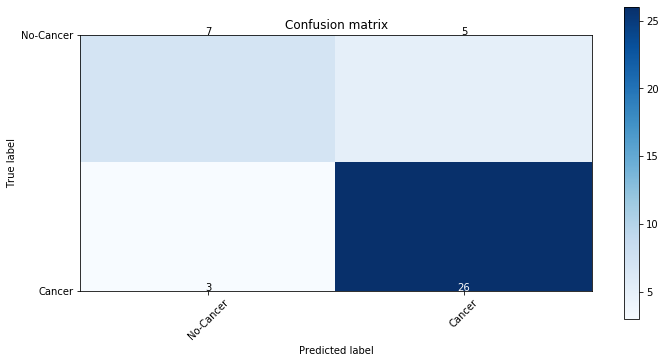

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 10}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(Y_test1, pred[1])
plt.figure(figsize=(10, 5))
plot_confusion_matrix(cnf_matrix, classes=['No-Cancer', 'Cancer'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [63]:
for i in [[RF2, Cat2, XGB2, LGBM2]]:
    fpr = []
    tpr = []
    roc_auc = []
    pred = []
    print('----------------------------------------------------------------------------------------------------')
    for j in i:
        
        #обучение модели
        j.fit(X_train2, Y_train2)

        #получение результата в виде 0 и 1
        pred1 = j.predict(X_test2)
        pred.append(pred1)
        #получение результата в виде вероятности

        score1 = j.predict_proba(X_test2)
        score1 = score1[:,1]

        #accuracy
        accuracy1 = accuracy_score(Y_test2, pred1)

        #f1
        f1_1 = f1_score(Y_test2, pred1)    

        #precision
        precision1 = precision_score(Y_test2,pred1)    

        #recall
        recall1 = recall_score(Y_test2,pred1)    

        #confusion_matrix
        cnf_matrix1 = confusion_matrix(Y_test2, pred1)    

        #roc_auc
        fpr1, tpr1, threshold1 = roc_curve(Y_test2,score1) 
        roc_auc1 = auc(fpr1, tpr1)  
        
        fpr.append(fpr1)
        tpr.append(tpr1)
        roc_auc.append(roc_auc1)
#----------------------------------------------------------------------------------------    
        print("Name model: ", type(j).__name__ )
        print("Confusion matrix: \n",cnf_matrix1)    
        print("Scores: accuracy = {:.4f}, \t precision = {:.2f}, \t recall = {:.2f}, \t f1 = {:.2f}, \t auc = {:.4f}"\
              .format(accuracy1, precision1, recall1, f1_1, roc_auc1))   
    
#----------------------------------------------------------------------------------------    
model_name = ['RF - AUC: {:.2f}', 
              'Cat - AUC: {:.2f}', 
              'XGB - AUC: {:.2f}',
              'LGBM - AUC: {:.2f}']

    # Построение ROC-AUC
    
      
marker = [dict(color='Crimson', width=3, dash='dash'),
         dict(color='SandyBrown', width=3, dash='dot'),
         dict(color='Blue', width=3, dash='dash'),
         dict(color='LimeGreen', width=3, dash='dot')]    

fig = go.Figure()

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)


for c in range(len(i)):

    name= model_name[c]

    fig.add_trace(go.Scatter(x=fpr[c],
                             y=tpr[c], 
                             name=name.format(roc_auc[c]),
                             line = marker[c]))


fig.update_layout(
    title_text="Вязкоупругие свойства",
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate')

fig.show()

print('----------------------------------------------------------------------------------------------------')

----------------------------------------------------------------------------------------------------
Name model:  RandomForestClassifier
Confusion matrix: 
 [[12  2]
 [ 2 29]]
Scores: accuracy = 0.9111, 	 precision = 0.94, 	 recall = 0.94, 	 f1 = 0.94, 	 auc = 0.9862
Name model:  CatBoostClassifier
Confusion matrix: 
 [[12  2]
 [ 2 29]]
Scores: accuracy = 0.9111, 	 precision = 0.94, 	 recall = 0.94, 	 f1 = 0.94, 	 auc = 0.9885
Name model:  XGBClassifier
Confusion matrix: 
 [[12  2]
 [ 2 29]]
Scores: accuracy = 0.9111, 	 precision = 0.94, 	 recall = 0.94, 	 f1 = 0.94, 	 auc = 0.9793
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Name model:  LGBMClassifier
Confusion matrix: 
 [[12  2]
 [ 2 29]]
Scores: accuracy = 0.9111, 	 precision = 0.94, 	 recall = 0.94, 	 f1 = 0.94, 	 auc = 0.9747


----------------------------------------------------------------------------------------------------


Confusion matrix, without normalization
[[12  2]
 [ 2 29]]


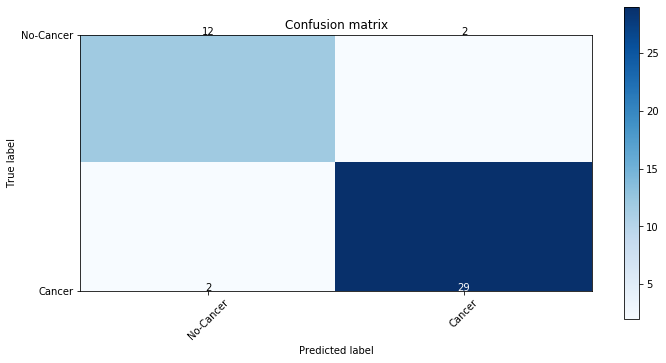

In [65]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 10}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(Y_test2, pred[1])
plt.figure(figsize=(10, 5))
plot_confusion_matrix(cnf_matrix, classes=['No-Cancer', 'Cancer'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [72]:
for i in [[Cat1, Cat2]]:
    fpr = []
    tpr = []
    roc_auc = []
    pred = []
    print('----------------------------------------------------------------------------------------------------')
    
        
    #обучение модели
    Cat1.fit(X_train1, Y_train1)

    #получение результата в виде 0 и 1
    pred1 = Cat1.predict(X_test1)
    pred.append(pred1)
    #получение результата в виде вероятности

    score1 = Cat1.predict_proba(X_test1)
    score1 = score1[:,1]

    #accuracy
    accuracy1 = accuracy_score(Y_test1, pred1)

    #f1
    f1_1 = f1_score(Y_test1, pred1)    

    #precision
    precision1 = precision_score(Y_test1,pred1)    

    #recall
    recall1 = recall_score(Y_test1,pred1)    

    #confusion_matrix
    cnf_matrix1 = confusion_matrix(Y_test1, pred1)    

    #roc_auc
    fpr1, tpr1, threshold1 = roc_curve(Y_test1,score1) 
    roc_auc1 = auc(fpr1, tpr1)  

    fpr.append(fpr1)
    tpr.append(tpr1)
    roc_auc.append(roc_auc1)
#----------------------------------------------------------------------------------------    

        
        
    #обучение модели
    Cat2.fit(X_train2, Y_train2)

    #получение результата в виде 0 и 1
    pred1 = Cat2.predict(X_test2)
    pred.append(pred1)
    #получение результата в виде вероятности

    score1 = Cat2.predict_proba(X_test2)
    score1 = score1[:,1]

    #accuracy
    accuracy1 = accuracy_score(Y_test2, pred1)

    #f1
    f1_1 = f1_score(Y_test2, pred1)    

    #precision
    precision1 = precision_score(Y_test2,pred1)    

    #recall
    recall1 = recall_score(Y_test2,pred1)    

    #confusion_matrix
    cnf_matrix1 = confusion_matrix(Y_test2, pred1)    

    #roc_auc
    fpr1, tpr1, threshold1 = roc_curve(Y_test2,score1) 
    roc_auc1 = auc(fpr1, tpr1)  

    fpr.append(fpr1)
    tpr.append(tpr1)
    roc_auc.append(roc_auc1)

        
        
    
model_name = ['Cat_ЛП - AUC: {:.2f}', 
              'Cat_ВУХ - AUC: {:.2f}']

# Построение ROC-AUC
    
      
marker = [dict(color='Crimson', width=3, dash='dash'),
         dict(color='Blue', width=3, dash='dot')] 

fig = go.Figure()

fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)


for c in range(len(i)):

    name= model_name[c]

    fig.add_trace(go.Scatter(x=fpr[c],
                             y=tpr[c], 
                             name=name.format(roc_auc[c]),
                             line = marker[c]))


fig.update_layout(
    title_text="ROC AUC",
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate')

fig.show()

print('----------------------------------------------------------------------------------------------------')

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


На отложенной выборке в обоих случаях самой точной моделью получилась модель обученная только на ВУХ показателях крови, хоти на кросс-валидации был другой результат. Возможно это связано с переобучением моделей, либо из-за большого кол-ва шумовых признаков

Так как для оценки **precision, recall, f1** мы получали на выходе из модели не вероятности отнесение к каждому классу, а модель сама определяла к какому классу относится пациент, определим порог (**Treshold**) отнесение отнесению к классу 1 для достижение **Recall = 1** на основе predict_proba (получение результата отнесения к классу в виде вероятности).


Так как модели дают примерно одинаковый результат, для рассмотрение возьмем catboost. В качестве trashold будем рассматривать пароги от 0.1 до 0.9 с шагом 0.1

In [25]:
Cat1.fit(X_train1, Y_train1)
score = Cat1.predict_proba(X_test1)
score = score[:,1]


for i in np.array(list(range(1, 10, 1)))*0.1:
    pred = []
    for j in score:
        if j < i:
            pred.append(0)
        else: pred.append(1)  
            
    print('Treshold: ', i)  
    print('Accuracy: ', accuracy_score(Y_test1, pred)) 
    print('F1 score: ', f1_score(Y_test1, pred)) 
    print('Точность: ', precision_score(Y_test1, pred)) 
    print('Полнота: ', recall_score(Y_test1, pred)) 
    print('-------------------------------------------')    

Treshold:  0.1
Accuracy:  0.7073170731707317
F1 score:  0.8285714285714285
Точность:  0.7073170731707317
Полнота:  1.0
-------------------------------------------
Treshold:  0.2
Accuracy:  0.7317073170731707
F1 score:  0.8405797101449275
Точность:  0.725
Полнота:  1.0
-------------------------------------------
Treshold:  0.30000000000000004
Accuracy:  0.7317073170731707
F1 score:  0.835820895522388
Точность:  0.7368421052631579
Полнота:  0.9655172413793104
-------------------------------------------
Treshold:  0.4
Accuracy:  0.7804878048780488
F1 score:  0.8571428571428571
Точность:  0.7941176470588235
Полнота:  0.9310344827586207
-------------------------------------------
Treshold:  0.5
Accuracy:  0.8048780487804879
F1 score:  0.8666666666666666
Точность:  0.8387096774193549
Полнота:  0.896551724137931
-------------------------------------------
Treshold:  0.6000000000000001
Accuracy:  0.7804878048780488
F1 score:  0.847457627118644
Точность:  0.8333333333333334
Полнота:  0.86206896

In [26]:
Cat2.fit(X_train2, Y_train2)
score = Cat2.predict_proba(X_test2)
score = score[:,1]


for i in np.array(list(range(1, 10, 1)))*0.1:
    pred = []
    for j in score:
        if j < i:
            pred.append(0)
        else: pred.append(1)  
            
    print('Treshold: ', i)  
    print('Accuracy: ', accuracy_score(Y_test2, pred)) 
    print('F1 score: ', f1_score(Y_test2, pred)) 
    print('Точность: ', precision_score(Y_test2, pred)) 
    print('Полнота: ', recall_score(Y_test2, pred)) 
    print('-------------------------------------------')    

Treshold:  0.1
Accuracy:  0.8444444444444444
F1 score:  0.898550724637681
Точность:  0.8157894736842105
Полнота:  1.0
-------------------------------------------
Treshold:  0.2
Accuracy:  0.8888888888888888
F1 score:  0.9253731343283582
Точность:  0.8611111111111112
Полнота:  1.0
-------------------------------------------
Treshold:  0.30000000000000004
Accuracy:  0.9333333333333333
F1 score:  0.9538461538461539
Точность:  0.9117647058823529
Полнота:  1.0
-------------------------------------------
Treshold:  0.4
Accuracy:  0.9333333333333333
F1 score:  0.9538461538461539
Точность:  0.9117647058823529
Полнота:  1.0
-------------------------------------------
Treshold:  0.5
Accuracy:  0.9111111111111111
F1 score:  0.9354838709677419
Точность:  0.9354838709677419
Полнота:  0.9354838709677419
-------------------------------------------
Treshold:  0.6000000000000001
Accuracy:  0.9555555555555556
F1 score:  0.9666666666666666
Точность:  1.0
Полнота:  0.9354838709677419
---------------------

С целью достижения полноты равной 100% необходимо выбирать Trashold = 0.3 для моделей обученных на характеристиках ВУХ и ЛП, для модели обученной только на ВУХ Treshold можно поднять до Trashold = 0.4, а для модели обученной только на ЛП Treshold нужно опустить до Trashold = 0.2.

Посмотрим какие важность каждой фичи для обучения каждой модели

### Определение важности фичей

#### Пояснения графика feature_importances для Random Forest:
- Чем выше фича, тем она важнее.
- Важность фичи определяна относительной величиной.

#### Пояснение к графику SHAP
- Фичи проранжированы по важности (сверху самые важные)
- Значения слева от центральной вертикальной линии — это negative класс (пациент болен), справа — positive (пациент здоров). 
- Чем толще линия на графике, тем больше таких точек наблюдения.
- Чем краснее точки на графике, тем выше значения фичи в ней.


#### Определение важности фичей для модели обученных на характеристиках ВУХ и ЛП

In [27]:
#Посмотрим важность фичей на RandomForest
importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]


plt.figure(figsize=[20,100])
plt.title("Значимость признаков для Random Forest All")

plt.barh(range(trainset.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(trainset.shape[1]), trainset.columns[indices], rotation=0)
plt.ylim([-1, trainset.shape[1]])
plt.gca().invert_yaxis()
plt.show()

NameError: name 'RF' is not defined

In [28]:
# Важность фичей для catboost
shap_test = shap.TreeExplainer(Cat).shap_values(X_train)
shap.summary_plot(shap_test, X_train,
                   max_display=30, auto_size_plot=True)

NameError: name 'Cat' is not defined

#### Определение важности фичей для модели обученных на характеристиках ВУХ

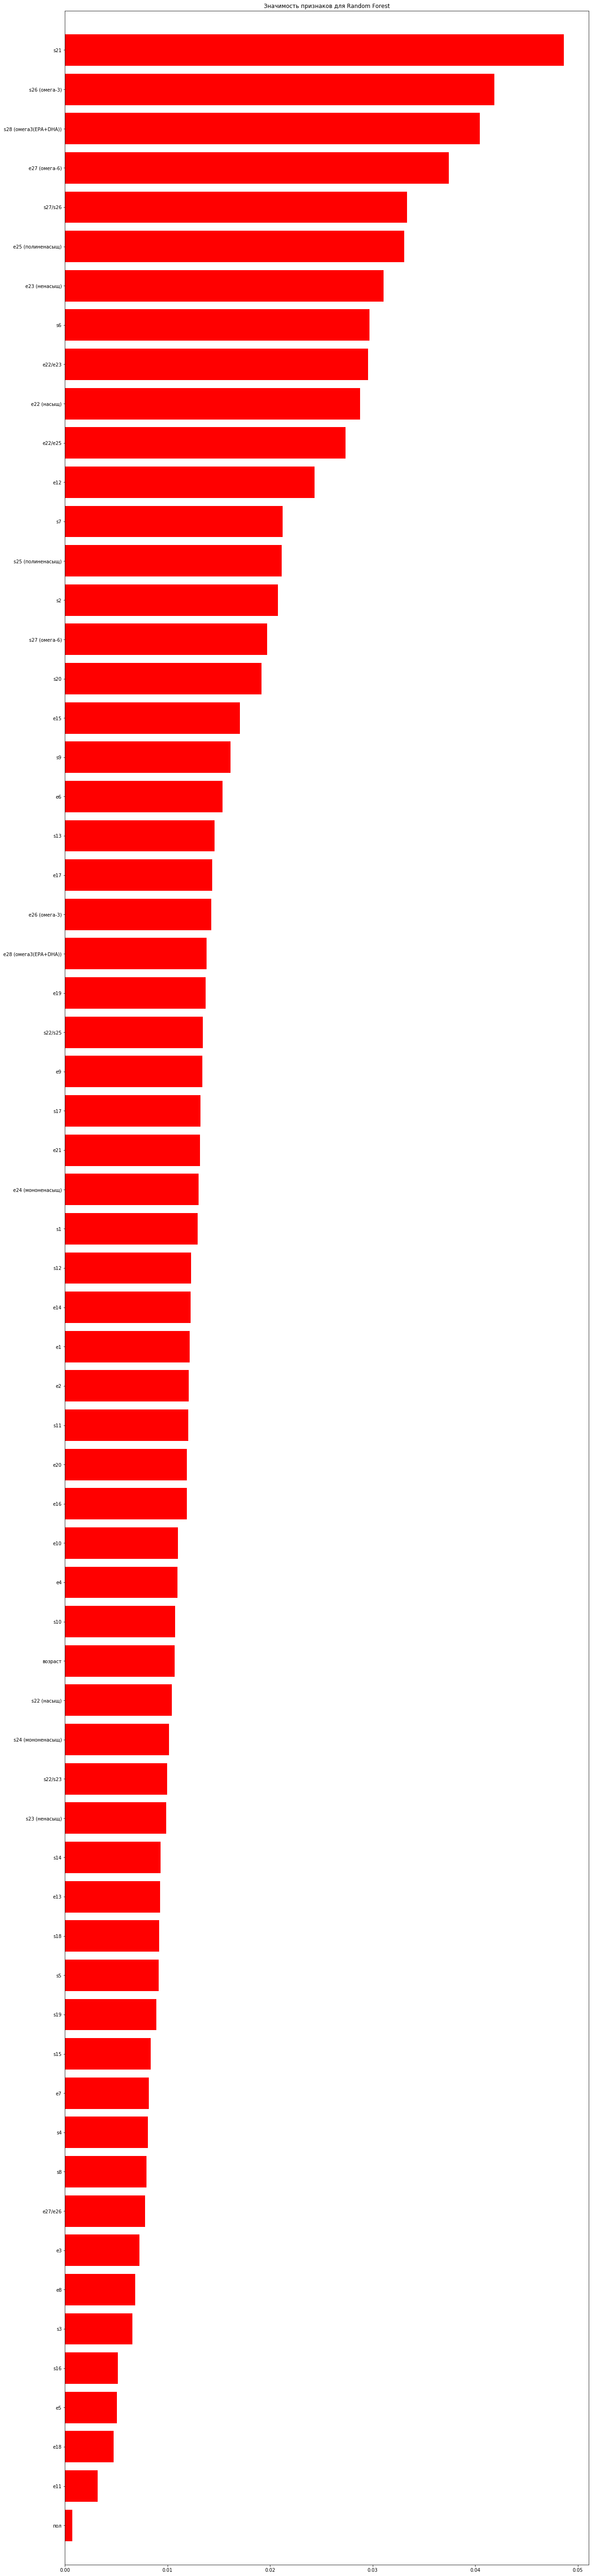

In [29]:
#Посмотрим важность фичей на RandomForest
importances = RF1.feature_importances_
indices = np.argsort(importances)[::-1]


plt.figure(figsize=[20,100])
plt.title("Значимость признаков для Random Forest")

plt.barh(range(trainset1.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(trainset1.shape[1]), trainset1.columns[indices], rotation=0)
plt.ylim([-1, trainset1.shape[1]])
plt.gca().invert_yaxis()
plt.show()

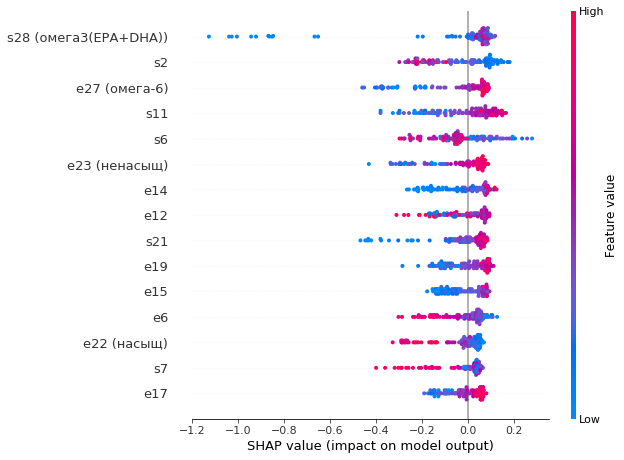

In [73]:
# Важность фичей для catboost
shap_test = shap.TreeExplainer(Cat1).shap_values(X_train1)
shap.summary_plot(shap_test, X_train1,
                   max_display=15, auto_size_plot=True)

#### Определение важности фичей для модели обученных на характеристиках ЛП

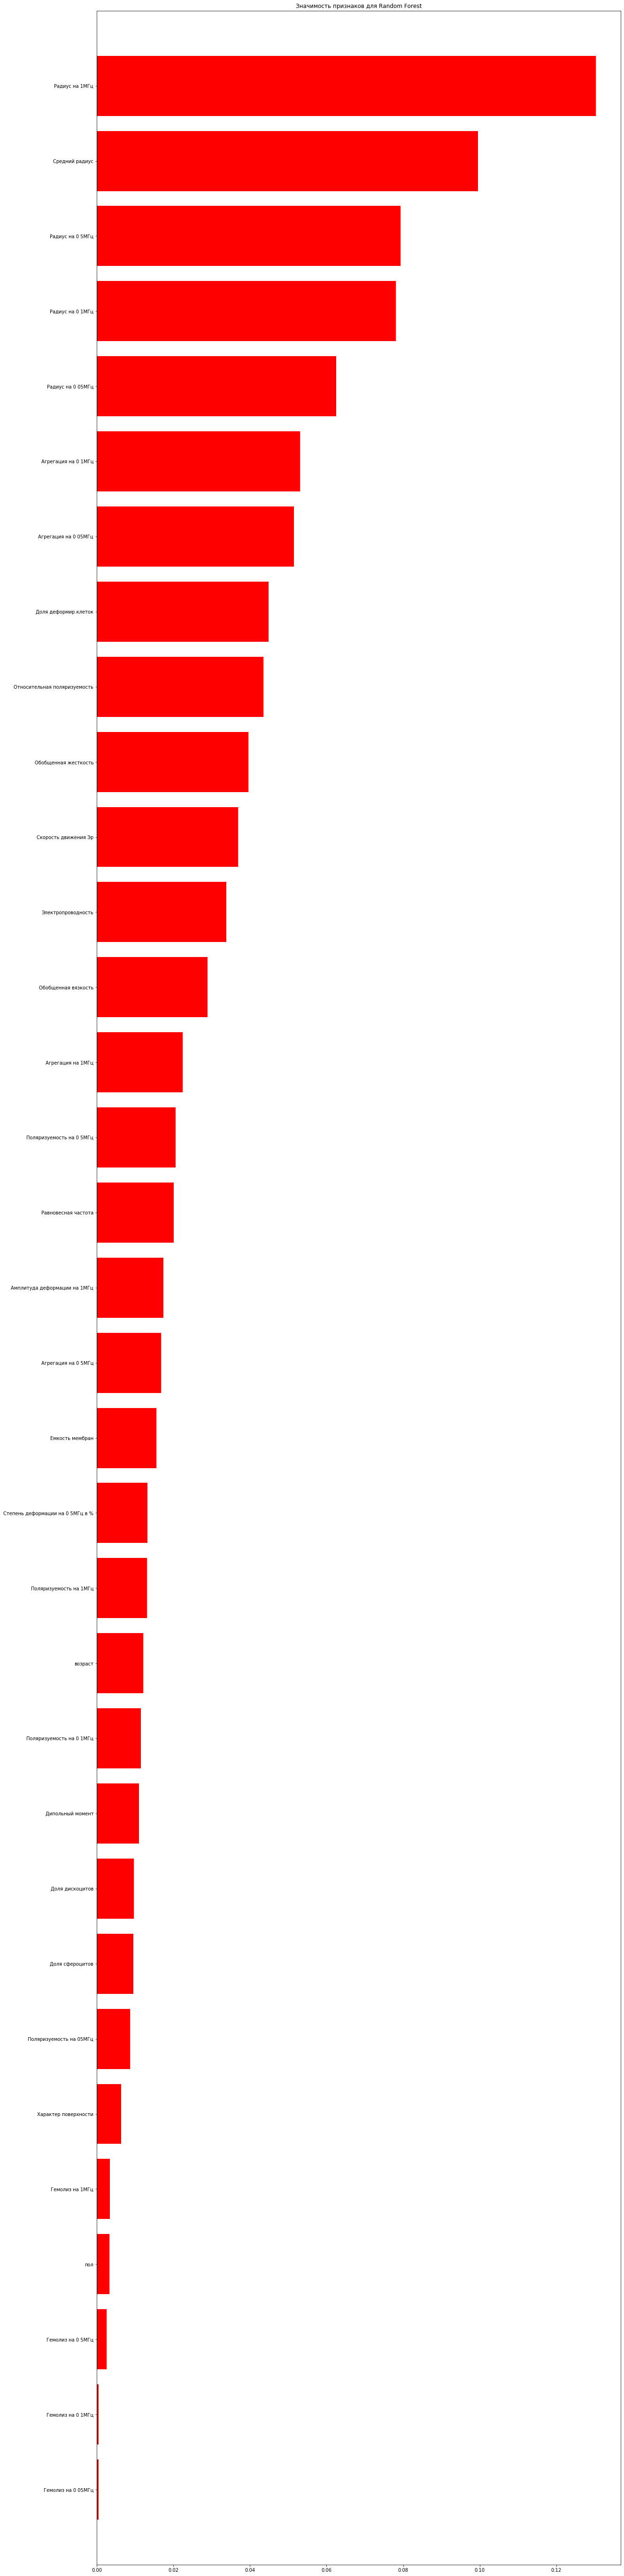

In [45]:
#Посмотрим важность фичей на RandomForest
importances = RF2.feature_importances_
indices = np.argsort(importances)[::-1]


plt.figure(figsize=[20,100])
plt.title("Значимость признаков для Random Forest")

plt.barh(range(trainset2.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(trainset2.shape[1]), trainset2.columns[indices], rotation=0)
plt.ylim([-1, trainset2.shape[1]])
plt.gca().invert_yaxis()
plt.show()

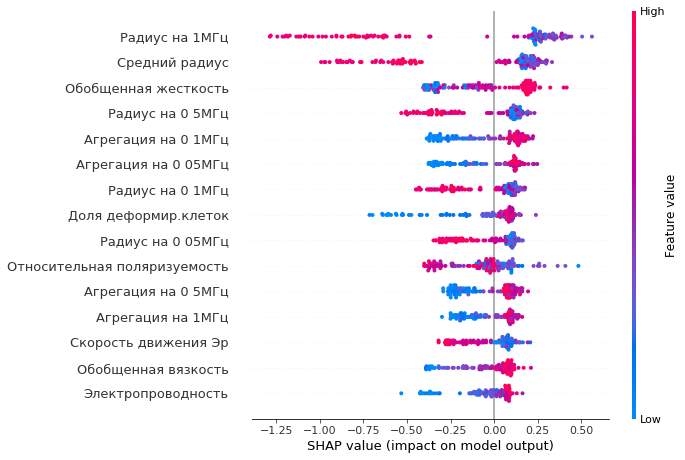

In [74]:
# Важность фичей для catboost
shap_test = shap.TreeExplainer(Cat2).shap_values(X_train2)
shap.summary_plot(shap_test, X_train2,
                   max_display=15, auto_size_plot=True)

###  2. Многоклассовая классификация для определения стадии рака

Для многоклассовой классификации воспользуемся двумя самыми основным подходом **One-Vs-All**. Суть заключается в том, что на каждом этапе мы распознаем с какой вероятностью пациент относится к одному определенному классу. Т.е. имеем дело с бинарной классификации. Число итераций равняется числу классов. После последней итерации определяется к какому классу с большей вероятностью относится пациент.

In [30]:
# посмотри насколько сбалансированы классы
df['стадия'].value_counts(normalize = True)*100

0.0    30.487805
3.0    26.219512
2.0    24.390244
4.0    12.195122
1.0     6.707317
Name: стадия, dtype: float64

In [31]:
# посмотри насколько сбалансированы классы
df_2['стадия'].value_counts(normalize = True)*100

0.0    30.508475
2.0    26.553672
3.0    24.858757
4.0    11.299435
1.0     6.779661
Name: стадия, dtype: float64

Так как классы имеют сильный дисбаланс, необходимо для обучения также использовать стратифицированную выборку

In [32]:
#в данном случае целевой меткой будет являться стадия
df['стадия'] = df['стадия'].astype(int)

trainset = df.drop(columns=['стадия', 'ФИО', 'стадия_0_1'])
target = df[['стадия']]

X_train, X_test, Y_train, Y_test = train_test_split(trainset, target, random_state = 17,
                                                    test_size=0.25, stratify=target)

#----------------------------------------------------------------------------------------    

df_1['стадия'] = df_1['стадия'].astype(int)

trainset1 = df_1.drop(columns=['стадия', 'ФИО', 'стадия_0_1'])
target1 = df_1[['стадия']]

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(trainset1, target1, random_state = 17,
                                                    test_size=0.25, stratify=target1)

#----------------------------------------------------------------------------------------    


df_2['стадия'] = df_2['стадия'].astype(int)

trainset2 = df_2.drop(columns=['стадия', 'ФИО', 'стадия_0_1'])
target2 = df_2[['стадия']]

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(trainset2, target2, random_state = 17,
                                                    test_size=0.25, stratify=target2)


In [33]:
# задаим параметры модели аналогичные пункту выше
# в данном случае также оставим веса классификации, так как нам 
#наиболее важно выявить наиболее тяжелую стадию рака
RF = RandomForestClassifier(random_state = 13, max_depth = 5, 
                            n_estimators = 100, class_weight={0:.3, 1:.7})
# n_estimators = 500, max_depth=6 - лучшие параметры согласно  greed search cv
Cat = CatBoostClassifier(random_state = 13, verbose = 0, 
                         n_estimators = 400, max_depth=7, 
                         class_weights = [0.3, 0.7])

#----------------------------------------------------------------------------------------

RF1 = RandomForestClassifier(random_state = 13, max_depth = 7, 
                            n_estimators = 400, class_weight={0:.3, 1:.7})
# n_estimators = 400, max_depth=7 - лучшие параметры согласно  greed search cv
Cat1 = CatBoostClassifier(random_state = 13, verbose = 0, 
                         n_estimators = 400, max_depth=7, 
                         class_weights = [0.3, 0.7])

#----------------------------------------------------------------------------------------


RF2 = RandomForestClassifier(random_state = 13, max_depth = 6, 
                            n_estimators = 200, class_weight={0:.3, 1:.7})
# n_estimators = 300, max_depth=8 - лучшие параметры согласно  greed search cv
Cat2 = CatBoostClassifier(random_state = 13, verbose = 0, 
                         n_estimators = 300, max_depth=8, 
                         class_weights = [0.3, 0.7])

In [34]:
# создадим модели
Cat_OvA = OneVsRestClassifier(Cat)
RF_OvA = OneVsRestClassifier(RF)
# обучим модели
Cat_OvA.fit(X_train, Y_train)
RF_OvA.fit(X_train, Y_train)

#----------------------------------------------------------------------------------------

# создадим модели
Cat_OvA1 = OneVsRestClassifier(Cat1)
RF_OvA1 = OneVsRestClassifier(RF1)
# обучим модели
Cat_OvA1.fit(X_train1, Y_train1)
RF_OvA1.fit(X_train1, Y_train1)
#----------------------------------------------------------------------------------------
# создадим модели
Cat_OvA2 = OneVsRestClassifier(Cat2)
RF_OvA2 = OneVsRestClassifier(RF2)
# обучим модели
Cat_OvA2.fit(X_train2, Y_train2)
RF_OvA2.fit(X_train2, Y_train2)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight={0: 0.3,
                                                                   1: 0.7},
                                                     criterion='gini',
                                                     max_depth=6,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                   

In [35]:
# получим предсказания классов без установки trashold
check = pd.DataFrame()
check['Class_Cat'] = Cat_OvA.predict(X_test)
check['Class_RF'] = RF_OvA.predict(X_test)
check['Class_Real'] = Y_test.values
# определим метрики Right_Cat и Right_RF, которые принимают 1, если класс распознан верно, иначе 0
check['Right_Cat'] = np.where(check['Class_Cat'] == check['Class_Real'],
                              1,
                              0)
check['Right_RF'] = np.where(check['Class_RF'] == check['Class_Real'],
                              1,
                              0)

# определим метрики Mis_Cat и Mis_RF, которые принимают 1, 
#если пациент был болен, а его модель определила здоровым

check['Miss_Cat'] = np.where((check['Class_Real'] != 0)&(check['Class_Cat'] == 0),
                              1,
                              0)
check['Miss_RF'] = np.where((check['Class_Real'] != 0)&(check['Class_RF'] == 0),
                              1,
                              0)

#----------------------------------------------------------------------------------------

# получим предсказания классов без установки trashold
check1 = pd.DataFrame()
check1['Class_Cat'] = Cat_OvA1.predict(X_test1)
check1['Class_RF'] = RF_OvA1.predict(X_test1)
check1['Class_Real'] = Y_test1.values
# определим метрики Right_Cat и Right_RF, которые принимают 1, если класс распознан верно, иначе 0
check1['Right_Cat'] = np.where(check1['Class_Cat'] == check1['Class_Real'],
                              1,
                              0)
check1['Right_RF'] = np.where(check1['Class_RF'] == check1['Class_Real'],
                              1,
                              0)

# определим метрики Mis_Cat и Mis_RF, которые принимают 1, 
#если пациент был болен, а его модель определила здоровым

check1['Miss_Cat'] = np.where((check1['Class_Real'] != 0)&(check1['Class_Cat'] == 0),
                              1,
                              0)
check1['Miss_RF'] = np.where((check1['Class_Real'] != 0)&(check1['Class_RF'] == 0),
                              1,
                              0)

#----------------------------------------------------------------------------------------


# получим предсказания классов без установки trashold
check2 = pd.DataFrame()
check2['Class_Cat'] = Cat_OvA2.predict(X_test2)
check2['Class_RF'] = RF_OvA2.predict(X_test2)
check2['Class_Real'] = Y_test2.values
# определим метрики Right_Cat и Right_RF, которые принимают 1, если класс распознан верно, иначе 0
check2['Right_Cat'] = np.where(check2['Class_Cat'] == check2['Class_Real'],
                              1,
                              0)
check2['Right_RF'] = np.where(check2['Class_RF'] == check2['Class_Real'],
                              1,
                              0)

# определим метрики Mis_Cat и Mis_RF, которые принимают 1, 
#если пациент был болен, а его модель определила здоровым

check2['Miss_Cat'] = np.where((check2['Class_Real'] != 0)&(check2['Class_Cat'] == 0),
                              1,
                              0)
check2['Miss_RF'] = np.where((check2['Class_Real'] != 0)&(check2['Class_RF'] == 0),
                              1,
                              0)


In [43]:
print(' Accuracy RF: {:.2%}\n Accuracy Cat: {:.2%}\n Missing RF: {:.2%}\n Missing Cat: {:.2%}'\
                         .format((check['Right_RF'].sum()/check.shape[0]),
                                 (check['Right_Cat'].sum()/check.shape[0]),
                                 (check['Miss_RF'].sum()/check.shape[0]),
                                 (check['Miss_Cat'].sum()/check.shape[0])))

 Accuracy RF: 80.49%
 Accuracy Cat: 75.61%
 Missing RF: 2.44%
 Missing Cat: 2.44%


Таким образом, при многоклассовой классификации мы получили следующие результаты:
- 1. Точность распознования класса при применении модели Random Forest 80.49%
- 2. Точность распознования класса при применении модели Catboost 75.61%
- 3. Ошибка, когда пациент болен, а модель его распознала здоровым, всего одна! Причем на самом деле у пациента имеется 3 стадия рака, а модели предсказали, что человек здоров.  

Рассмотрим какие вероятности отнесения к классам были у пациента, которые имеет индекс 26

In [38]:
Cat_OvA.predict_proba(X_test)[26]

array([0.3838072 , 0.01845824, 0.31781759, 0.26321181, 0.01670517])

In [39]:
RF_OvA.predict_proba(X_test)[26]

array([0.33336543, 0.0164103 , 0.31501672, 0.30943924, 0.02576831])

Видно, что в данном случае вероятности отнесения к классу 0, 2 и 3 достаточно близки и если установить порог принятия решений относить пациента к классу не равным нулю задать определенной величиной, а не выбирать наибольшую вероятность, то таких ошибок удасться избежать, но возможно пострадает Accuracy в общем по всем классам. **Например**, если процент отнесению к любому из склассов, кроме 0, выше 0.3, то мы считаем пациента больным. Кстати говоря, именно этот порог и был нами определен в первом части построения моделей, при бинарной классификации.

In [46]:
print('Модель обученная только на ЛП')
print(' Accuracy RF: {:.2%}\n Accuracy Cat: {:.2%}\n Missing RF: {:.2%}\n Missing Cat: {:.2%}'\
                         .format((check1['Right_RF'].sum()/check1.shape[0]),
                                 (check1['Right_Cat'].sum()/check1.shape[0]),
                                 (check1['Miss_RF'].sum()/check1.shape[0]),
                                 (check1['Miss_Cat'].sum()/check1.shape[0])))

Модель обученная только на ЛП
 Accuracy RF: 41.46%
 Accuracy Cat: 41.46%
 Missing RF: 14.63%
 Missing Cat: 17.07%


In [47]:
print('Модель обученная только на ВУХ')
print(' Accuracy RF: {:.2%}\n Accuracy Cat: {:.2%}\n Missing RF: {:.2%}\n Missing Cat: {:.2%}'\
                         .format((check2['Right_RF'].sum()/check2.shape[0]),
                                 (check2['Right_Cat'].sum()/check2.shape[0]),
                                 (check2['Miss_RF'].sum()/check2.shape[0]),
                                 (check2['Miss_Cat'].sum()/check2.shape[0])))

Модель обученная только на ВУХ
 Accuracy RF: 80.00%
 Accuracy Cat: 77.78%
 Missing RF: 4.44%
 Missing Cat: 2.22%
